# SDP implementations

> Thales B. S. F. Rodrigues
> 
> Federal University of Juiz de Fora, Brazil  

<p style="text-align: right;">A <a href="https://jupyter.org/">Jupyter Notebook</a></p>

In this notebook, the semidefinite programs proposed in the master's thesis [1] are implemented and evaluated through four different coarse-graining scenarios.

## Installs and imports

In [ ]:
#requirements 

#cvxpy 
#mosek
#qiskit
#typing 
#pickle
#os 

%reload_ext autoreload
%autoreload 2

import scipy
from scipy.stats import unitary_group
import cvxpy as cp
import qiskit as qt
from qiskit.quantum_info import Choi
from qiskit.quantum_info import diamond_norm
from typing import Optional, Tuple, List, Dict, Callable
import pickle
import importlib
import os

path_mosek = r"C:\Users\fonse\OneDrive\Área de Trabalho\CG-SDP-benchmarking\mosek.lic" #Change to your own path
os.environ["MOSEKLM_LICENSE_FILE"] = path_mosek 

import mosek 
from utils import *


## Generators definition

In [ ]:
#Maximally entangled state
rho_ent =  (1/2)*  np.array([[1,0,0,1],
                      [0,0,0,0],
                      [0,0,0,0],
                      [1,0,0,1]])

#Maximally mixed state
rho_mix =  (1/4)*  np.array([[1,0,0,0],
                            [0,1,0,0],
                            [0,0,1,0],
                            [0,0,0,1]])


#Werner state
l = 1/3 #Setting the state used in the text
rho_werner = generate_werner_Bell_projection(l)


#Random state
np.random.seed(0)
A = np.random.randint(10, size=(d_A, d_A))  + 1j * np.random.randint(10, size=(d_A, d_A))
rho_random = A @ A.conj().T
rho_random = (1/np.trace(rho_random))*rho_random



initial_states = [rho_ent, rho_mix, rho_werner, rho_random]
initial_states_str = ["rho_ME","rho_MM","rho_werner","rho_random"]

## Feasibility:   $\Gamma_{D|C}$

$\Gamma_{D|C} : \Gamma_{D|C} \circ \Lambda^{CG}_{C|A} = \Lambda^{CG}_{D|B} \circ \mathcal{U}_{B|A} $

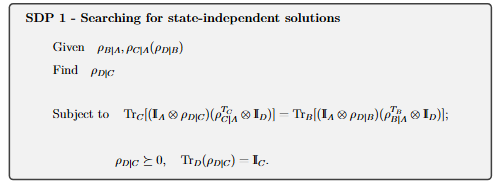

In [2]:
def find_GammaChoi_feasibility(choi_CG,choi_U, d_A, d_B, d_C, d_D):

    #Setting the SDP variables
    choi_Gamma = cp.Variable((d_C * d_D, d_C * d_D), hermitian=True) # \in L(H_C ⊗ H_D})

    # Constraints
    constraints = []

    # 1. Commutation relation (without rho_A dependence) constraint
    # Computing the left hand side
    rho_ACD = cp.kron(np.eye(d_A),choi_Gamma) @ cp.kron(cp.partial_transpose(choi_CG,dims=[d_A,d_C],axis=1),np.eye(d_D))
    lhs = cp.partial_trace(rho_ACD,dims=[d_A,d_C,d_D],axis=1) #Partial trace over C

    # Computing the right hand side
    rho_ABD = cp.kron(np.eye(d_A),choi_CG) @ cp.kron(cp.partial_transpose(choi_U,dims=[d_A,d_B],axis=1),np.eye(d_D))
    rhs = cp.partial_trace(rho_ABD,dims=[d_A,d_B,d_D],axis=1) #Partial trace over B


    # Appending the constraint on the constraints list
    constraints.append(lhs == rhs)

    # 2. Acausal conditional state constraints
    constraints += [
        choi_Gamma >> 0,
        cp.partial_trace(choi_Gamma, dims=[d_C, d_D], axis=1) == np.eye(d_C)
    ]


    prob = cp.Problem(cp.Minimize(0), constraints) #Feasibility problem
    prob.solve(solver=cp.MOSEK, verbose=False)

    if prob.status == cp.OPTIMAL:
        return choi_Gamma.value
    else:
        print("No feasible solution found.")
        return None, None

#To do: Make a systematic test for all scenarios

if __name__ == "__main__":

    # Defining the number of rows and columns of the operators in each regions
    d_A = 4
    d_B = 4
    d_C = 2
    d_D = 2

    #Defining the given choi states
    choi_CG_blur = calc_choi_CG(d_A,d_C,coarse_graining_blursatur)
    choi_CG_trace =  calc_choi_CG(d_A,d_C, coarse_graining_partial_trace_B)

    choi_U_swap = calc_choi_U(d_A,d_B,unitary_channel_swap)
    choi_U_sigma  = calc_choi_U(d_A,d_B, unitary_channel_sigma_z(t=1))

    #Running the feasibility SDP
    choi_Gamma_opt_solution = find_GammaChoi_feasibility(choi_CG_blur,choi_U_swap, d_A, d_B, d_C, d_D)

    print("\n Optimal solution achieved:")
    print(choi_Gamma_opt_solution)

Error: rescode.err_missing_license_file(1008): License cannot be located. The default search path is ';C:\Users\fonse\mosek\mosek.lic;'.


### Diamond norm distances

In [ ]:
diamond_distances_feasibility = {}

#Running the feasibility SDP (without rho_A dependence in the commutation constraint)
choi_Gamma_feasible = find_GammaChoi_feasibility(choi_CG_blur,choi_U_swap, d_A, d_B, d_C, d_D)

for i in range(len(initial_states)):
    #Constructing the Choi states for a fixed rho_A constructor
    rho_A_ctc = initial_states[i]
    choi_Gamma_Petz = calc_choi_Gamma_petz_act(d_C,d_D,petz_recovery_map(rho_A_ctc,kraus_CG()),coarse_graining_blursatur,unitary_channel_swap)
    diamond_distances_feasibility[initial_states_str[i]] = float(round(diamond_norm(Choi(choi_Gamma_feasible) - Choi(choi_Gamma_Petz),solver="MOSEK"),4))

# Diamond norm distances
print("\n Diamond norm distance between the Gamma Petz and the Gamma feasible")
print(diamond_distances_feasibility)




 Diamond norm distance between the Gamma Petz and the Gamma feasible
{'rho_MM': 0.4226, 'rho_ME': 1.6667, 'rho_werner': 0.5528, 'rho_random': 0.7068, 'rho_test': 0.5035}


### Searching for state-independent solutions close to $\Gamma^{\text{Petz}}$




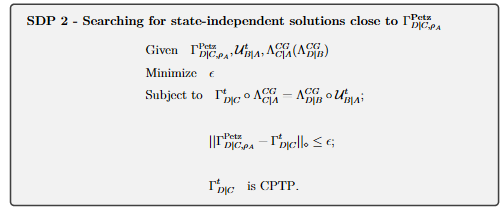

In [ ]:
def epsilon_Minimization_SDP(choi_CG, choi_Gamma_Petz,choi_U, d_A, d_B, d_C, d_D):

  """
    Find the optimal Choi matrix  that minimizes the diamond-norm distance
    to a given Petz map, under commutativity and CPTP constraints.

    Parameters:
        choi_CG : numpy.ndarray
            Choi matrix representing the coarse-graining map CG.
        choi_Gamma_Petz : numpy.ndarray
            Choi matrix of the \Gamma^{Petz}  map.
        choi_U : numpy.ndarray
            Choi matrix representing the unitary channel U.
        d_A : int
            Dimension of region A.
        d_B : int
            Dimension of region B.
        d_C : int
            Dimension of region C.
        d_D : int
            Dimension of region D.

    Returns:
        tuple:
            choi_Gamma : numpy.ndarray or None
                Optimal Choi matrix Γ that minimizes the diamond-norm distance
                to Γ_Petz, satisfying the imposed constraints.
            epsilon : float or None
                Minimum diamond-norm distance value ε. If no feasible solution
                is found, returns None.
"""

    #Setting the SDP variables
    choi_Gamma = cp.Variable((d_C * d_D, d_C * d_D), hermitian=True) # \in L(H_C ⊗ H_D})
    epsilon = cp.Variable()
    Z1 = cp.Variable((d_C * d_D, d_C * d_D), hermitian=True) # \in L(H_C ⊗ H_D})
    Z2 = cp.Variable((d_C * d_D, d_C * d_D), hermitian=True) # \in L(H_C ⊗ H_D})


    # Constraints
    constraints = []

    # 1. Commutation relation (without rho_A dependence) constraint
    # Computing the left hand side
    rho_ACD = cp.kron(np.eye(d_A),choi_Gamma) @ cp.kron(cp.partial_transpose(choi_CG,dims=[d_A,d_C],axis=1),np.eye(d_D))
    lhs = cp.partial_trace(rho_ACD,dims=[d_A,d_C,d_D],axis=1) #Partial trace over C

    # Computing the right hand side
    rho_ABD = cp.kron(np.eye(d_A),choi_CG) @ cp.kron(cp.partial_transpose(choi_U,dims=[d_A,d_B],axis=1),np.eye(d_D))
    rhs = cp.partial_trace(rho_ABD,dims=[d_A,d_B,d_D],axis=1) #Partial trace over B

    # Storing the commuting relation constraint
    constraints.append(lhs == rhs)


    # 2. Diamond norm ball constraints
    constraints += [
        choi_Gamma_Petz - choi_Gamma == Z2 - Z1,
        Z1 >> 0,
        Z2 >> 0,
        epsilon * np.eye(d_C) >>  cp.partial_trace(Z1 + Z2, dims=[d_C, d_D], axis=1)
        ]

    # 3. Acausal conditional state constraints
    constraints += [
        choi_Gamma >> 0,
        cp.partial_trace(choi_Gamma, dims=[d_C, d_D], axis=1) == np.eye(d_C)
    ]

    # Minimize epsilon
    prob = cp.Problem(cp.Minimize(epsilon), constraints) #Feasibility problem with epsilon-minimization
    prob.solve(solver=cp.MOSEK, verbose=False)

    if prob.status == cp.OPTIMAL:
        return choi_Gamma.value, epsilon.value
    else:
        print("No feasible solution found.")
        return None, None

#To do: again, do the systematic approach
if __name__ == "__main__":

    # Defining the number of rows and columns of the operators in each regions
    d_A = 4
    d_B = 4
    d_C = 2
    d_D = 2


    #Defining the given choi states
    choi_CG_blur = calc_choi_CG(d_A,d_C,coarse_graining_blursatur)
    choi_CG_trace =  calc_choi_CG(d_A,d_C, coarse_graining_partial_trace_B)

    choi_U_swap = calc_choi_U(d_A,d_B,unitary_channel_swap)
    choi_U_sigma  = calc_choi_U(d_A,d_B, unitary_channel_sigma_z(t=1))
    choi_U_id = calc_choi_U(d_A, d_B, id_channel)

    #Defining the recovery map for a given generator
    recovery_map = petz_recovery_map(rho_werner, kraus_CG())

    #Generating the choi gamma Petz
    choi_gamma_Petz = calc_choi_Gamma_petz_act(d_C, d_D, recovery_map, coarse_graining_blursatur,unitary_channel_swap)

    #Running the feasibility SDP
    choi_Gamma_opt_solution, epsilon_opt = epsilon_Minimization_SDP(choi_CG_blur, choi_gamma_Petz, choi_U_swap, d_A, d_B, d_C, d_D)

    print("\n Optimal solution achieved:")
    print(choi_Gamma_opt_solution)

    print("\n Optimal epsilon achieved")
    print(epsilon_opt)

    print("\nDiamond norm between the solution and the target:")
    print(diamond_norm(Choi(choi_gamma_Petz) - Choi(choi_Gamma_opt_solution)))


 Optimal solution achieved:
[[ 1.+0.j  0.+0.j -0.+0.j  1.+0.j]
 [ 0.+0.j -0.+0.j  0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j -0.+0.j -0.+0.j]
 [ 1.+0.j  0.+0.j -0.+0.j  1.+0.j]]

 Optimal epsilon achieved
0.5527864045379909

Diamond norm between the solution and the target:
0.5527873444994336


## Robustness aspects

### CG-robustness measure

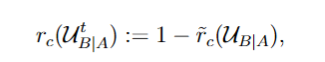

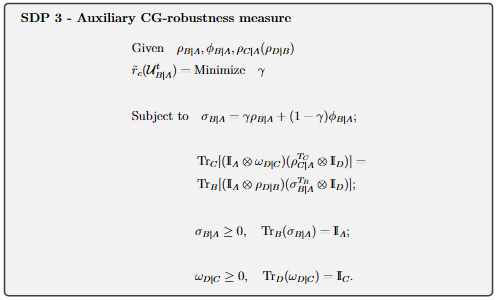

In [ ]:
def findRobustness(choi_CG,choi_U_compatible, choi_U_noise , d_A, d_B, d_C, d_D):

    #Setting the SDP variables
    choi_Gamma = cp.Variable((d_C * d_D, d_C * d_D), hermitian=True) # \in L(H_C ⊗ H_D})
    choi_U_combination = cp.Variable((d_A * d_B, d_A * d_B), hermitian=True) # \in L(H_A ⊗ H_B})
    gamma = cp.Variable() #Robustness parameter
    constraints = []

    # 1. Convex combination constraint
    constraints.append(choi_U_combination == gamma *choi_U_compatible + (1 - gamma)*choi_U_noise)

    # 2. Commutation relation (without rho_A dependence) constraint
    # Computing the left hand side
    rho_ACD = cp.kron(np.eye(d_A),choi_Gamma) @ cp.kron(cp.partial_transpose(choi_CG,dims=[d_A,d_C],axis =1),np.eye(d_D))
    lhs = cp.partial_trace(rho_ACD,dims=[d_A,d_C,d_D],axis=1) #Partial trace over C
    # Computing the right hand side
    rho_ABD = cp.kron(np.eye(d_A),choi_CG) @ cp.kron(cp.partial_transpose(choi_U_combination,dims=[d_A,d_B],axis=1),np.eye(d_D))
    rhs = cp.partial_trace(rho_ABD,dims=[d_A,d_B,d_D],axis=1) #Partial trace over B
    # Appending the constraint on the constraints list
    constraints.append(lhs == rhs)

    # 3. Causal conditional state of the unitary channel constraints
    constraints += [
       choi_U_combination >> 0,
        cp.partial_trace(choi_U_combination, dims=[d_A, d_B], axis=1) == np.eye(d_A)
    ]

    # 4. Causal conditional state of the macroscopic dynamics constraints
    constraints += [
        choi_Gamma >> 0,
        cp.partial_trace(choi_Gamma, dims=[d_C, d_D], axis=1) == np.eye(d_C)
    ]

    # 5. Robustness parameter constraint
   # constraints += [r >= 0, r <= 1] #OBS: imposing that choi_U_com >=0 already constrained it

    prob = cp.Problem(cp.Minimize(gamma), constraints) #Caculating the \Tilde{r}_c quantity
    prob.solve(solver=cp.MOSEK, verbose=False)

    #Defining the CG-robustness measure based on it
    CG_robustness = float(1 - gamma.value)

    if prob.status == cp.OPTIMAL:
        return CG_robustness, choi_Gamma.value, choi_U_combination.value
    else:
        print("No feasible solution found.")
        return None, None,None



if __name__ == "__main__":

    # Defining the number of rows and columns of the operators in each regions
    d_A = 4
    d_B = 4
    d_C = 2
    d_D = 2

    #Defining the given choi states
    choi_CG_blur = calc_choi_CG(d_A,d_C,coarse_graining_blursatur)
    choi_CG_trace = calc_choi_CG(d_A,d_C, coarse_graining_partial_trace_B)
    choi_U_compatible = calc_choi_U(d_A,d_B,unitary_channel_swap)
    choi_U_noise = calc_choi_U(d_A,d_B,unitary_channel_sigma_z(t=1))

    #Running the minimization SDP
    r, choi_Gamma, choi_U_combination = findRobustness(choi_CG_blur,choi_U_compatible, choi_U_noise, d_A, d_B, d_C, d_D)
    print("\nRobustness achieved (t=1 on the noise unitary):")
    print(r)
    print("\nGamma Choi:")
    print(choi_Gamma)
    print("\nDiamond distance between choi_U_combination and choi_U_compatible :")
    print(diamond_norm(Choi(choi_U_combination) - Choi(choi_U_compatible),solver="MOSEK"))






Robustness achieved (t=1 on the noise unitary):
6.361133841892297e-12

Gamma Choi:
[[ 1.+0.j -0.+0.j -0.+0.j  1.+0.j]
 [-0.-0.j -0.+0.j  0.-0.j  0.-0.j]
 [-0.-0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 1.-0.j  0.+0.j  0.-0.j  1.+0.j]]

Diamond distance between choi_U_combination and choi_U_compatible :
7.34616756175248e-18


#### Random unitary

In [ ]:
def random_unitary_channel(input):
  #Generating a random sample from U(4)
  U = unitary_group.rvs(4)
  return U @ input @ U.conj().T

if __name__ == "__main__":

    # Defining the number of rows and columns of the operators in each regions
    d_A = 4
    d_B = 4
    d_C = 2
    d_D = 2

    resulting_parameter = []

    #Defining the fixed Choi state of the coarse graining channel
    choi_CG_blur = calc_choi_CG(d_A,d_C,coarse_graining_blursatur)

    #Defining the fixed Choi state of the SWAP channel
    choi_U_swap = calc_choi_U(d_A,d_B,unitary_channel_swap)

    #Testing the program for n = 10000 random unitary channels
    for i in range(1000):
      #print("\nIteration: {}".format(i))
      #Generating the Choi state of the random unitary channel
      choi_U_random = calc_choi_U(d_A,d_B,random_unitary_channel)
      #Finding the robustness using the random unitary channel
      r, choi_Gamma, choi_U = findRobustness(choi_CG_blur,choi_U_swap, choi_U_random, d_A, d_B, d_C, d_D)
      #print("\nRobustness achieved:")
      #print(r)
      #print("\nGamma Choi:")
      #print(choi_Gamma)
      #print("\nDiamond distance between choi_U_comb and choi_U_swap :")
      #print(diamond_norm(Choi(choi_U_comb) - Choi(choi_U_swap),solver="MOSEK"))
      resulting_parameter.append(r)
      print("Iteration:{}".format(i))
      print("Robustness measure:{}".format(r))
      print("\n")
      #print("====================================================================================")
    print(max(resulting_parameter))

#CONCLUSIONS:
# 1 - Any convex combination of a unitary which commutes with a unitary that doesn't commutes the diagram, will not be a feasible solution, due to the linear propertie of the commuting constraint.


In [ ]:
#Random "product" unitary

def random_product_unitary_channel(input):
  #Generating a random sample from U(2)
  U1 = unitary_group.rvs(2)
  U2 = unitary_group.rvs(2)

  #Tensoring to the get the product unitary
  U = np.kron(U1,U2)

  return U @ input @ U.conj().T


if __name__ == "__main__":

    # Defining the number of rows and columns of the operators in each regions
    d_A = 4
    d_B = 4
    d_C = 2
    d_D = 2

    resulting_parameter2 = []
    choi_U_comb2_list = []
    choi_Gamma2_list = []

    #Defining the fixed Choi state of the coarse graining channel
    choi_CG = calc_choi_CG(d_A,d_C,coarse_graining_blursatur)

    #Defining the fixed Choi state of the SWAP channel
    choi_U_swap = calc_choi_U(d_A,d_B,unitary_channel_swap)


    #Testing the program for n = 10000 random unitary channels
    for i in range(1000):
      print("\nIteration: {}".format(i))
      #Generating the Choi state of the random product unitary channel
      choi_U_random_product = calc_choi_U(d_A,d_B,random_product_unitary_channel)
      #Finding the robustness using the random unitary channel
      r2, _, _ = findRobustness(choi_CG,choi_U_swap, choi_U_random_product, d_A, d_B, d_C, d_D)


      resulting_parameter2.append(r2)
      print("Iteration:{}".format(i))
      print("Robustness measure:{}".format(r2))
      print("\n")
      #print("====================================================================================")

    print("Maximum robustness achieved: {}".format(max(resulting_parameter2)))

### Robustness-inspired SDP



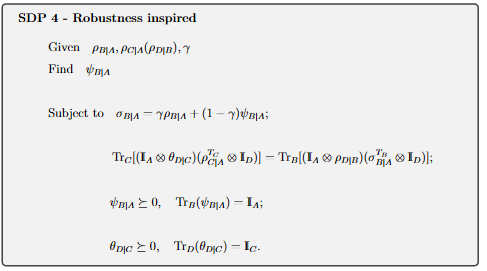

In [ ]:
def RobustnessInspiredSDP(choi_CG,choi_U_fixed,gamma, d_A, d_B, d_C, d_D):

    #Setting the SDP variables
    choi_Theta = cp.Variable((d_C * d_D, d_C * d_D), hermitian=True) # \in L(H_C ⊗ H_D})
    choi_J_resultant = cp.Variable((d_A * d_B, d_A * d_B), hermitian=True) # \in L(H_A ⊗ H_B})
    choi_psi_noise = cp.Variable((d_A * d_B, d_A * d_B), hermitian=True) # \in L(H_A ⊗ H_B})

    # Constraints
    constraints = []

    # 1. Convex combination constraint
    constraints.append(choi_J_resultant == gamma * choi_U_fixed + (1 - gamma) * choi_psi_noise)

    # 2. Commutation relation (without rho_A dependence) constraint
        # Computing the left hand side
    rho_ACD = cp.kron(np.eye(d_A),choi_Theta) @ cp.kron(cp.partial_transpose(choi_CG,dims=[d_A,d_C],axis =1),np.eye(d_D))
    lhs = cp.partial_trace(rho_ACD,dims=[d_A,d_C,d_D],axis=1) #Partial trace over C
        # Computing the right hand side
    rho_ABD = cp.kron(np.eye(d_A),choi_CG) @ cp.kron(cp.partial_transpose(choi_J_resultant,dims=[d_A,d_B],axis=1),np.eye(d_D))
    rhs = cp.partial_trace(rho_ABD,dims=[d_A,d_B,d_D],axis=1) #Partial trace over B

    # Appending the constraint on the constraints list
    constraints.append(lhs == rhs)

    # 3. Acausal conditional state of the noised unitary channel constraints
    constraints += [
       choi_psi_noise >> 0,
        cp.partial_trace(choi_psi_noise, dims=[d_A, d_B], axis=1) == np.eye(d_A)
    ]

    # 4. Acausal conditional state of the Gamma channel constraint
    constraints += [
        choi_Theta >> 0,
        cp.partial_trace(choi_Theta, dims=[d_C, d_D], axis=1) == np.eye(d_C)
    ]

    prob = cp.Problem(cp.Minimize(0), constraints) #Feasibility problem
    prob.solve(solver=cp.MOSEK, verbose=False)

    if prob.status == cp.OPTIMAL:
        return choi_Theta.value, choi_psi_noise.value,choi_J_resultant.value
    else:
        print("No feasible solution found.")
        return [0], [0],[0]

   #Conclusions:
   # 1 - For gamma = 0, choi_J_resultant == choi_U_feasible
   # 2 - For gamma = 1, choi_J_resultant == choi_U_swap
   # 3 - For   0<gamma <1, choi_J_resultant and choi_U_feasible represents new channels in which, setting the coarse-graining, the diagram commutes



#### Testing for the non compatible scenarios: 2,3 and 4

##### Setup 2: BnS and z-interaction channel

In [ ]:
if __name__ == "__main__":

    # Defining the number of rows and columns of the operators in each regions
    d_A = 4
    d_B = 4
    d_C = 2
    d_D = 2

    #Setting the convex combination parameter lambda
    cc_parameters = np.linspace(0,1,1500)

    #Defining the fixed Choi state of the coarse graining channel
    choi_CG_blur = calc_choi_CG(d_A,d_C,coarse_graining_blursatur)

    #Defining the fixed Choi state of the z-interaction channel
    choi_U_sigma = calc_choi_U(d_A,d_B,unitary_channel_sigma_z(t=1))

    #Saving the results
    found_noised_micro_dynamics_setup2 = []
    resultants_macro_dynamics_setup2 = []
    resultants_micro_dynamics_setup2 = []
    parameters_where_breaks_setup2 = []
    parameters_where_works_setup2 = []


    for gamma in cc_parameters:
        choi_Theta_resultants_macro, choi_psi_noise, choi_resultant_micro = RobustnessInspiredSDP(choi_CG_blur,choi_U_sigma,gamma, d_A, d_B, d_C, d_D)
        if len(choi_Theta_resultants_macro) == 1:
          print("The program breaks at gamma = {}".format(gamma))
          parameters_where_breaks_setup2.append(gamma)
          #continue
          break
        else:
          print("Saving the results for gamma={}".format(gamma))
          parameters_where_works_setup2.append(gamma)
          resultants_macro_dynamics_setup2.append(choi_Theta_resultants_macro)
          found_noised_micro_dynamics_setup2.append(choi_psi_noise)
          resultants_micro_dynamics_setup2.append(choi_resultant_micro)


In [ ]:
#Highest value where it works
max_gamma_setup2 = max(parameters_where_works_setup2)
print("Highest gamma-value where it works for Setup2: {}".format(max_gamma_setup2))

#Lowest value where it works
min_gamma_setup2 = min(parameters_where_works_setup2)
print("Lowest gamma-value where it works for Setup2: {}".format(min_gamma_setup2))

Highest gamma-value where it works for Setup2: 0.5570380253502334
Lowest gamma-value where it works for Setup2: 0.0


##### Setup 3: Partial trace and SWAP channel

In [ ]:

if __name__ == "__main__":

    # Defining the number of rows and columns of the operators in each regions
    d_A = 4
    d_B = 4
    d_C = 2
    d_D = 2

    #Setting the convex combination parameter gamma
    cc_parameters = np.linspace(0,1,1500)

    #Defining the fixed Choi state of the coarse graining partial trace
    choi_CG_trace = calc_choi_CG(d_A,d_C,coarse_graining_partial_trace_B)

    #Defining the fixed Choi state of the SWAP channel
    choi_U_swap = calc_choi_U(d_A,d_B,unitary_channel_swap)

    #Saving the results
    found_noised_micro_dynamics_setup3 = []
    resultants_macro_dynamics_setup3 = []
    resultants_micro_dynamics_setup3 = []
    parameters_where_breaks_setup3 = []
    parameters_where_works_setup3 = []

    for gamma in cc_parameters:
        #Running the optimization program
        choi_Theta_resultants_macro, choi_psi_noise, choi_resultant_micro = RobustnessInspiredSDP(choi_CG_trace,choi_U_swap,gamma, d_A, d_B, d_C, d_D)

        if len(choi_Theta_resultants_macro) == 1:
          print("The program breaks at gamma = {}".format(gamma))
          parameters_where_breaks_setup3.append(gamma)
          #continue
          break
        else:
          print("Saving the results for gamma={}".format(gamma))
          parameters_where_works_setup3.append(gamma)
          resultants_macro_dynamics_setup3.append(choi_Theta_resultants_macro)
          found_noised_micro_dynamics_setup3.append(choi_psi_noise)
          resultants_micro_dynamics_setup3.append(choi_resultant_micro)


In [ ]:
#Highest value where it works
max_gamma_setup3 = max(parameters_where_works_setup3)
print("Highest gamma-value where it works for Setup3: {}".format(max_gamma_setup3))

#Lowest value where it works
min_gamma_setup3 = min(parameters_where_works_setup3)
print("Lowest gamma-value where it works for Setup3: {}".format(min_gamma_setup3))

Highest gamma-value where it works for Setup3: 0.24949966644429616
Lowest gamma-value where it works for Setup3: 0.0


##### Setup 4: Partial trace and z-interaction channel

In [ ]:

if __name__ == "__main__":

    # Defining the number of rows and columns of the operators in each regions
    d_A = 4
    d_B = 4
    d_C = 2
    d_D = 2

    #Setting the convex combination parameter gamma
    cc_parameters = np.linspace(0,1,1500)

    #Defining the fixed Choi state of the coarse graining partial trace
    choi_CG_trace = calc_choi_CG(d_A,d_C,coarse_graining_partial_trace_B)

    #Defining the fixed Choi state of the z-interaction channel
    choi_U_sigma = calc_choi_U(d_A,d_B,unitary_channel_sigma_z(t=1))

    #Saving the results
    found_noised_micro_dynamics_setup4 = []
    resultants_macro_dynamics_setup4 = []
    resultants_micro_dynamics_setup4 = []
    parameters_where_breaks_setup4 = []
    parameters_where_works_setup4 = []

    for gamma in cc_parameters:
        #Running the optimization program
        choi_Theta_resultants_macro, choi_psi_noise, choi_resultant_micro = RobustnessInspiredSDP(choi_CG_trace,choi_U_sigma,gamma, d_A, d_B, d_C, d_D)

        if len(choi_Theta_resultants_macro) == 1:
          print("The program breaks at gamma = {}".format(gamma))
          parameters_where_breaks_setup4.append(gamma)
          #continue
          break
        else:
          print("Saving the results for gamma={}".format(gamma))
          parameters_where_works_setup4.append(gamma)
          resultants_macro_dynamics_setup4.append(choi_Theta_resultants_macro)
          found_noised_micro_dynamics_setup4.append(choi_psi_noise)
          resultants_micro_dynamics_setup4.append(choi_resultant_micro)


In [ ]:
#Highest value where it works
max_gamma_setup4 = max(parameters_where_works_setup4)
print("Highest gamma-value where it works for Setup4: {}".format(max_gamma_setup4))

#Lowest value where it works
min_gamma_setup4 = min(parameters_where_works_setup4)
print("Lowest gamma-value where it works for Setup4: {}".format(min_gamma_setup4))

Highest gamma-value where it works for Setup4: 0.5236824549699799
Highest gamma-value where it works for Setup4: 0.0


##### Diamond norm computations

In [ ]:
#Setup 2
#Computing the diamond norm distance between the initial microscopic dynamics and the resultant
results_micro_distances_setup2 = []

for i in range(len(parameters_where_works_setup2)):
  print("Computing for parameter {} ...".format(parameters_where_works_setup2[i]))
  results_micro_distances_setup2.append(diamond_norm(Choi(resultants_micro_dynamics_setup2[i]) - Choi(choi_U_sigma)))


#Setup 3
#Computing the diamond norm distance between the initial microscopic dynamics and the resultant
results_micro_distances_setup3 = []

for i in range(len(parameters_where_works_setup3)):
  print("Computing for parameter {} ...".format(parameters_where_works_setup3[i]))
  results_micro_distances_setup3.append(diamond_norm(Choi(resultants_micro_dynamics_setup3[i]) - Choi(choi_U_swap)))

#Setup 4
#Computing the diamond norm distance between the initial microscopic dynamics and the resultant
results_micro_distances_setup4 = []

for i in range(len(parameters_where_works_setup4)):
  print("Computing for parameter {} ...".format(parameters_where_works_setup4[i]))
  results_micro_distances_setup4.append(diamond_norm(Choi(resultants_micro_dynamics_setup4[i]) - Choi(choi_U_sigma)))


##### Testing: Commutation relation

In [ ]:
#For the resultant dynamics in setup 2

resultant_micro_test = parameters_where_works_setup2[20]*choi_U_sigma + (1-parameters_where_works_setup2[20])*found_noised_micro_dynamics_setup2[20]
print("\nChecking manually the consistency of the convex combination. Diamond norm result:{}".format(diamond_norm(Choi(resultant_micro_test) - Choi(resultants_micro_dynamics_setup2[20]))))

rho_C = partial_trace(choi_CG_blur @ np.kron(rho_random.T, np.eye(d_C)), dims=[d_A, d_C], axis=0)
lhs = partial_trace(resultants_macro_dynamics_setup2[20] @ np.kron(rho_C.T,np.eye(d_D)), dims=[d_C,d_D],  axis=0)

rho_B = partial_trace(resultant_micro_test @ np.kron(rho_random.T, np.eye(d_B)), dims=[d_A, d_B], axis=0)
rhs = partial_trace(choi_CG_blur @ np.kron(rho_B.T, np.eye(d_D)), dims=[d_B, d_D], axis=0)

#Computing the trace norm of lhs - rhs
tr_norm = float(np.linalg.norm(lhs - rhs,ord='nuc').round(decimals=7))
print("Checkin manually the commutativy relation for a given state: {}".format(tr_norm))



Checking manually the consistency of the convex combination. Diamond norm result:1.2127590650728437e-18
Checkin manually the commutativy relation for a given state: 0.0


In [ ]:
#For the resultant dynamics in setup 3

resultant_micro_test = parameters_where_works_setup3[20]*choi_U_swap + (1-parameters_where_works_setup3[20])*found_noised_micro_dynamics_setup3[20]
print("\nChecking manually the consistency of the convex combination. Diamond norm result:{}".format(diamond_norm(Choi(resultant_micro_test) - Choi(resultants_micro_dynamics_setup3[20]))))

rho_C = partial_trace(choi_CG_trace @ np.kron(rho_ent.T, np.eye(d_C)), dims=[d_A, d_C], axis=0)
lhs = partial_trace(resultants_macro_dynamics_setup3[20] @ np.kron(rho_C.T,np.eye(d_D)), dims=[d_C,d_D],  axis=0)

rho_B = partial_trace(resultant_micro_test @ np.kron(rho_ent.T, np.eye(d_B)), dims=[d_A, d_B], axis=0)
rhs = partial_trace(choi_CG_trace @ np.kron(rho_B.T, np.eye(d_D)), dims=[d_B, d_D], axis=0)

#Computing the trace norm of lhs - rhs
tr_norm = float(np.linalg.norm(lhs - rhs,ord='nuc').round(decimals=7))
print("Checkin manually the commutativy relation for a given state: {}".format(tr_norm))


Checking manually the consistency of the convex combination. Diamond norm result:3.600226733934883e-19
Checkin manually the commutativy relation for a given state: 0.0


In [ ]:
#For the resultant dynamics in setup 4

resultant_micro_test = parameters_where_works_setup4[20]*choi_U_sigma + (1-parameters_where_works_setup4[20])*found_noised_micro_dynamics_setup4[20]
print("\nChecking manually the consistency of the convex combination. Diamond norm result:{}".format(diamond_norm(Choi(resultant_micro_test) - Choi(resultants_micro_dynamics_setup4[20]))))

rho_C = partial_trace(choi_CG_trace @ np.kron(rho_mix.T, np.eye(d_C)), dims=[d_A, d_C], axis=0)
lhs = partial_trace(resultants_macro_dynamics_setup4[20] @ np.kron(rho_C.T,np.eye(d_D)), dims=[d_C,d_D],  axis=0)

rho_B = partial_trace(resultant_micro_test @ np.kron(rho_mix.T, np.eye(d_B)), dims=[d_A, d_B], axis=0)
rhs = partial_trace(choi_CG_trace @ np.kron(rho_B.T, np.eye(d_D)), dims=[d_B, d_D], axis=0)

#Computing the trace norm of lhs - rhs
tr_norm = float(np.linalg.norm(lhs - rhs,ord='nuc').round(decimals=7))
print("Checkin manually the commutativy relation for a given state: {}".format(tr_norm))


Checking manually the consistency of the convex combination. Diamond norm result:8.792403058083607e-38
Checkin manually the commutativy relation for a given state: 0.0
